# **WORKING WITH STARTING DATA**

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install matplotlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Proper Imputation

In [4]:
import pandas as pd
import numpy as np
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

In [7]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

# Organizing columns
measure_cols = ['avgWeight_per_day', 'calories', 'heart', 'steps']
survey_cols = ['diet', 'medication', 'symptoms']
result_col = 'visit_day'

In [8]:
# Sets visit_day column nans to zero
def set_nan_zero(df, col):
    df[col] = df[col].fillna(0)
    return df

# Clears rows with empty columns to start
def prelim_row_removal(df, cols):
    cleaned_groups = []

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        to_remove = []

        for idx, row in group.iterrows():
            if row[cols].isna().all():
                to_remove.append(idx)
            else:
                break  # Stop as soon as we hit a row with any non-NaN value

        group = group.drop(index=to_remove)
        cleaned_groups.append(group)

    return pd.concat(cleaned_groups).reset_index(drop=True)


fitbit_data = set_nan_zero(fitbit_data, result_col)
fitbit_data = prelim_row_removal(fitbit_data, measure_cols)

In [158]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=fitbit_data)

https://docs.google.com/spreadsheets/d/139oBS4s4DWhPntNpgMqrJQVQJg9asOZw7qL78-Y2bCE/edit#gid=0


In [9]:
# Mark rows for removal, max is number of nans allowed in a window of time
def mark_day_for_removal(df, cols, max_nans, window):
    df = df.copy()
    df['remove'] = False

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()

        for col in cols:
            n = len(group)
            for start in range(n):
                end = min(start + window, n)
                window_slice = group.iloc[start:end]

                # Count NaNs in this window for this column
                nan_count = window_slice[col].isna().sum()

                if nan_count >= max_nans:
                    # Mark rows with NaN in this column for removal
                    for idx in window_slice.index:
                        if pd.isna(group.at[idx, col]):
                            df.at[idx, 'remove'] = True

    return df

def mark_week_for_removal(df, cols, max_nans, window):
    df = df.copy()
    df['remove'] = False

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        n = len(group)

        for col in cols:
            for start in range(n):
                end = min(start + window, n)
                window_slice = group.iloc[start:end]

                nan_count = window_slice[col].isna().sum()

                if nan_count >= max_nans:
                    # Mark all rows in the window for removal
                    for idx in window_slice.index:
                        df.at[idx, 'remove'] = True

    return df


fitbit_data = mark_day_for_removal(fitbit_data, measure_cols, 3, 7)

In [10]:
def impute_forward_fill(df, cols):
    df = df.copy()
    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        for col in cols:
            group[col] = group[col].ffill()  # forward fill
        df.loc[group.index, cols] = group[cols]
    return df

ffill_data = impute_forward_fill(fitbit_data, measure_cols)

In [ ]:
sheet = sheets.InteractiveSheet(df=ffill_data)

https://docs.google.com/spreadsheets/d/14A4vonfDXnbcNUTIetOqIULLHmk0PKYYggowzTlTZaM/edit#gid=0


In [11]:
# Rolling mean from n previous values
def impute_rolling_mean(df, cols, n):
    df = df.copy()
    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        for col in cols:
            group[col] = group[col].fillna(df[col].shift(1).rolling(window=n, min_periods=1).mean())
        df.loc[group.index, cols] = group[cols]
    return df

roll_mean_data = impute_rolling_mean(fitbit_data, measure_cols, 5)

In [ ]:
sheet = sheets.InteractiveSheet(df=roll_mean_data)

https://docs.google.com/spreadsheets/d/1Qxiud2XxDA15cNohgxGowWfttdRKkZDUZkzuGMk5IUI/edit#gid=0


In [12]:
def impute_EWMA(df, cols, n):
    df = df.copy()
    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        for col in cols:
            group[col] = group[col].fillna(df[col].shift(1).ewm(span=n, adjust=False).mean())
        df.loc[group.index, cols] = group[cols]
    return df

EWMA_data = impute_EWMA(fitbit_data, measure_cols, 10)

In [ ]:
sheet = sheets.InteractiveSheet(df=EWMA_data)

https://docs.google.com/spreadsheets/d/1AGdHB0vCDTZhqiNsMA71ZLPnEMPJ3Ur_IJ79FM6InJA/edit#gid=0


In [15]:
from typing_extensions import final
def final_clean(df, cols):
    df = df.copy()

    # Remove rows marked True in the 'remove' column
    df = df[df['remove'] != True]

    # Remove rows that have any NaN in the specified columns
    df = df.dropna(subset=cols)

    return df

final_rm_data = final_clean(roll_mean_data, measure_cols)
final_ff_data = final_clean(ffill_data, measure_cols)
final_ewma_data = final_clean(EWMA_data, measure_cols)

In [ ]:
sheet = sheets.InteractiveSheet(df=final_ewma_data)

https://docs.google.com/spreadsheets/d/15jCLfruNXc3XJPsdpIKybU2781DkuFNKnlFrUOxzK5U/edit#gid=0


In [ ]:
print(fitbit_data.shape)
print(fitbit_data.info())
print(fitbit_data.head())
print(fitbit_data.describe())

(44820, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44820 entries, 0 to 44819
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         44820 non-null  int64         
 1   date               44820 non-null  datetime64[ns]
 2   study_group        44820 non-null  object        
 3   fitbit_user_id     44820 non-null  int64         
 4   avgWeight_per_day  32886 non-null  float64       
 5   calories           41396 non-null  float64       
 6   heart              34401 non-null  float64       
 7   steps              41358 non-null  float64       
 8   diet               23857 non-null  float64       
 9   medication         23862 non-null  float64       
 10  symptoms           23866 non-null  float64       
 11  minutes_asleep     30702 non-null  float64       
 12  minutes_awake      30702 non-null  float64       
 13  days               44820 non-null  int64         

In [10]:
final_rm_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day,remove
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,2.0,2.0,1.0,NaN,NaN,0,NaN,NaN,0.0,False
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,1.0,2.0,1.0,270.0,46.0,1,NaN,NaN,0.0,False
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,1.0,2.0,0.0,141.0,23.0,2,NaN,NaN,0.0,False
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,2.0,2.0,0.0,172.0,53.0,3,NaN,NaN,0.0,False
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,2.0,2.0,0.0,99.0,5.0,4,NaN,NaN,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44772,44772,2025-01-28,No App,307,176.810524,3825.0,66.0,7495.0,NaN,NaN,NaN,NaN,NaN,132,NaN,NaN,0.0,False
44775,44775,2025-01-31,No App,307,198.415800,2290.0,65.0,4503.0,NaN,NaN,NaN,NaN,NaN,135,NaN,NaN,0.0,False
44776,44776,2025-02-01,No App,307,177.912834,2541.0,65.0,6247.0,NaN,NaN,NaN,NaN,NaN,136,NaN,NaN,0.0,False
44783,44783,2025-02-08,No App,307,182.652767,2683.0,65.0,10945.0,NaN,NaN,NaN,63.0,9.0,143,NaN,NaN,0.0,False


## Using some models

In [16]:
from sklearn.model_selection import GroupShuffleSplit

def group_split(df, group_col='fitbit_user_id', val_size=0.1, test_size=0.2, random_state=42):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(gss.split(df, groups=df[group_col]))

    df_train_val = df.iloc[train_val_idx].copy()
    df_test = df.iloc[test_idx].copy()

    gss_val = GroupShuffleSplit(n_splits=1, test_size=val_size / (1 - test_size), random_state=random_state)
    train_idx, val_idx = next(gss_val.split(df_train_val, groups=df_train_val[group_col]))

    df_train = df_train_val.iloc[train_idx].copy()
    df_val = df_train_val.iloc[val_idx].copy()

    return df_train, df_val, df_test

In [17]:
rm_train, rm_val, rm_test = group_split(final_rm_data)
ff_train, ff_val, ff_test = group_split(final_ff_data)
ewma_train, ewma_val, ewma_test = group_split(final_ewma_data)

In [14]:
rm_test

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day,remove
1440,1440,2021-09-02,App Money,11,213.407216,3109.0,61.0,10482.0,2.0,2.0,0.0,NaN,NaN,0,NaN,NaN,0.0,False
1441,1441,2021-09-03,App Money,11,223.328006,3174.0,65.0,11136.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0.0,False
1450,1450,2021-09-12,App Money,11,221.123386,2636.0,60.0,4191.0,2.0,2.0,0.0,373.0,53.0,10,NaN,NaN,0.0,False
1452,1452,2021-09-14,App Money,11,219.800614,2580.0,59.0,4892.0,1.0,2.0,0.0,NaN,NaN,12,NaN,NaN,0.0,False
1453,1453,2021-09-15,App Money,11,216.714146,2793.0,58.0,8432.0,2.0,2.0,0.0,267.0,37.0,13,NaN,NaN,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44386,44386,2024-11-21,App Money,304,204.588736,2857.0,52.0,8227.0,NaN,NaN,NaN,467.0,104.0,106,NaN,NaN,0.0,False
44389,44389,2024-11-24,App Money,304,205.470584,3363.0,50.0,10398.0,NaN,NaN,NaN,300.0,40.0,109,NaN,NaN,0.0,False
44401,44401,2024-12-06,App Money,304,207.564973,3091.0,50.0,8683.0,NaN,NaN,NaN,356.0,79.0,121,NaN,NaN,0.0,False
44408,44408,2024-12-13,App Money,304,208.446821,2793.0,49.0,7361.0,NaN,NaN,NaN,381.0,40.0,128,NaN,NaN,0.0,False


In [18]:
def split_data(df, in_cols, out_col):
  inputs = df[in_cols]
  outputs = df[out_col]
  return inputs, outputs

In [19]:
rm_test_in, rm_test_out = split_data(rm_test, measure_cols, result_col)
rm_val_in, rm_val_out = split_data(rm_val, measure_cols, result_col)
rm_train_in, rm_train_out = split_data(rm_train, measure_cols, result_col)

ff_test_in, ff_test_out = split_data(ff_test, measure_cols, result_col)
ff_val_in, ff_val_out = split_data(ff_val, measure_cols, result_col)
ff_train_in, ff_train_out = split_data(ff_train, measure_cols, result_col)

ewma_test_in, ewma_test_out = split_data(ewma_test, measure_cols, result_col)
ewma_val_in, ewma_val_out = split_data(ewma_val, measure_cols, result_col)
ewma_train_in, ewma_train_out = split_data(ewma_train, measure_cols, result_col)

In [25]:
rm_test_in

,avgWeight_per_day,calories,heart,steps
1440,213.407216,3109.0,61.0,10482.0
1441,223.328006,3174.0,65.0,11136.0
1450,221.123386,2636.0,60.0,4191.0
1452,219.800614,2580.0,59.0,4892.0
1453,216.714146,2793.0,58.0,8432.0
...,...,...,...,...
44386,204.588736,2857.0,52.0,8227.0
44389,205.470584,3363.0,50.0,10398.0
44401,207.564973,3091.0,50.0,8683.0
44408,208.446821,2793.0,49.0,7361.0


**Running RF Model**

In [20]:
from sklearn.ensemble import RandomForestClassifier

def run_rf(train_in, train_out, val_in, val_out):
  rf = RandomForestClassifier(n_jobs=-1, random_state=42)
  rf.fit(train_in, train_out)
  print(rf.score(train_in, train_out))
  print(rf.score(val_in, val_out))
  return rf


In [21]:
rf_rm = run_rf(rm_train_in, rm_train_out, rm_val_in, rm_val_out)
rf_ff = run_rf(ff_train_in, ff_train_out, ff_val_in, ff_val_out)
rf_ewma = run_rf(ewma_train_in, ewma_train_out, ewma_val_in, ewma_val_out)

1.0
0.5082164328657315
0.9999505219929741
0.49278267842822776
0.9999011613540895
0.4945935122146576


In [172]:
train_probs = rf_rm.predict_proba(rm_train_in)
train_probs

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

rm_pred = rf_rm.predict(rm_train_in)
ff_pred = rf_ff.predict(ff_train_in)
ewma_pred = rf_ewma.predict(ewma_train_in)

In [174]:
print("Confusion Matrix:")
print(confusion_matrix(rm_train_out, rm_pred))
print("\nClassification Report:")
print(classification_report(rm_train_out, rm_pred))

print("Confusion Matrix:")
print(confusion_matrix(ff_train_out, ff_pred))
print("\nClassification Report:")
print(classification_report(ff_train_out, ff_pred))

print("Confusion Matrix:")
print(confusion_matrix(ewma_train_out, ewma_pred))
print("\nClassification Report:")
print(classification_report(ewma_train_out, ewma_pred))

Confusion Matrix:
[[19673     0]
 [    0   557]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19673
         1.0       1.00      1.00      1.00       557

    accuracy                           1.00     20230
   macro avg       1.00      1.00      1.00     20230
weighted avg       1.00      1.00      1.00     20230

Confusion Matrix:
[[19654     0]
 [    0   557]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19654
         1.0       1.00      1.00      1.00       557

    accuracy                           1.00     20211
   macro avg       1.00      1.00      1.00     20211
weighted avg       1.00      1.00      1.00     20211

Confusion Matrix:
[[19678     0]
 [    0   557]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19678
         1.0      

In [23]:
rm_pred = rf_rm.predict(rm_test_in)
ff_pred = rf_ff.predict(ff_test_in)
ewma_pred = rf_ewma.predict(ewma_test_in)

In [176]:
print("Confusion Matrix:")
print(confusion_matrix(rm_test_out, rm_pred))
print("\nClassification Report:")
print(classification_report(rm_test_out, rm_pred))

print("Confusion Matrix:")
print(confusion_matrix(ff_test_out, ff_pred))
print("\nClassification Report:")
print(classification_report(ff_test_out, ff_pred))

print("Confusion Matrix:")
print(confusion_matrix(ewma_test_out, ewma_pred))
print("\nClassification Report:")
print(classification_report(ewma_test_out, ewma_pred))

Confusion Matrix:
[[5258   49]
 [ 281    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      5307
         1.0       0.00      0.00      0.00       281

    accuracy                           0.94      5588
   macro avg       0.47      0.50      0.48      5588
weighted avg       0.90      0.94      0.92      5588

Confusion Matrix:
[[5246   53]
 [ 279    2]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      5299
         1.0       0.04      0.01      0.01       281

    accuracy                           0.94      5580
   macro avg       0.49      0.50      0.49      5580
weighted avg       0.90      0.94      0.92      5580

Confusion Matrix:
[[5270   38]
 [ 281    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      5308
         1.0       0.00      0

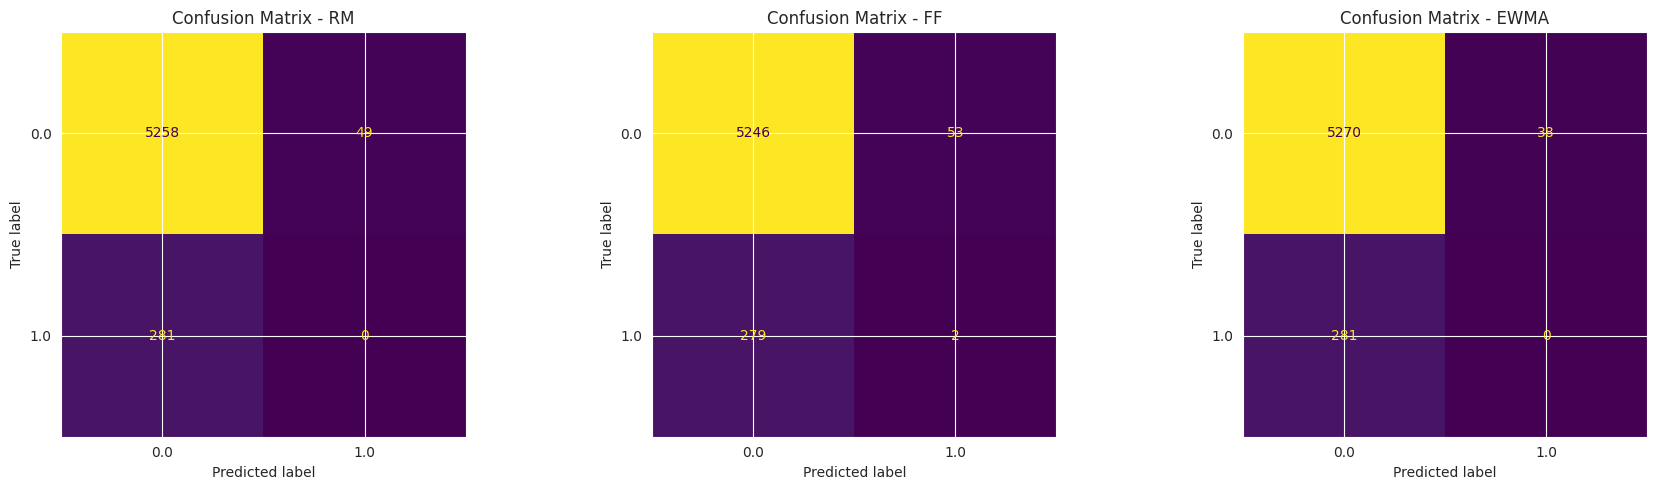

In [177]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# First confusion matrix (rm_test_out vs rm_pred)
ConfusionMatrixDisplay.from_predictions(rm_test_out, rm_pred, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - RM")

# Second confusion matrix (ff_test_out vs ff_pred)
ConfusionMatrixDisplay.from_predictions(ff_test_out, ff_pred, ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix - FF")

# Third confusion matrix (again ff_test_out vs ff_pred, assuming it's for a different model/config)
ConfusionMatrixDisplay.from_predictions(ewma_test_out, ewma_pred, ax=axes[2], colorbar=False)
axes[2].set_title("Confusion Matrix - EWMA")

plt.tight_layout()
plt.show()


In [178]:
rm_proba = rf_rm.predict_proba(rm_test_in)[:, 1]  # Probabilities for class 1
rm_pred = rf_rm.predict(rm_test_in)               # Binary predictions

ff_proba = rf_ff.predict_proba(ff_test_in)[:, 1]  # Probabilities for class 1
ff_pred = rf_ff.predict(ff_test_in)               # Binary predictions

ewma_proba = rf_ewma.predict_proba(ewma_test_in)[:, 1]  # Probabilities for class 1
ewma_pred = rf_ewma.predict(ewma_test_in)               # Binary predictions

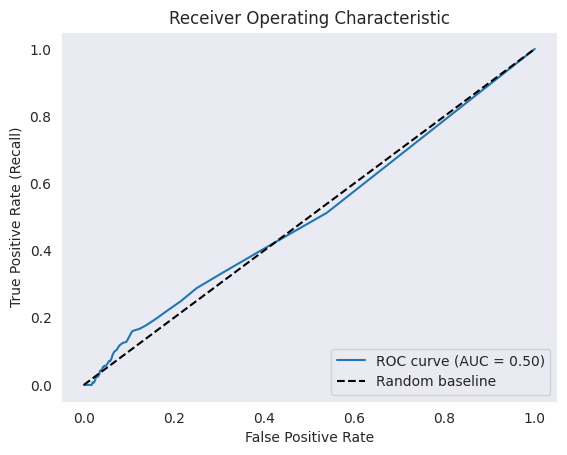

In [179]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(rm_test_out, rm_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()


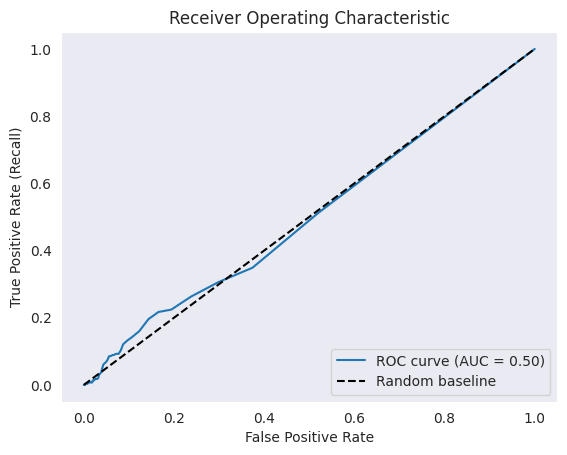

In [180]:
fpr, tpr, _ = roc_curve(ff_test_out, ff_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

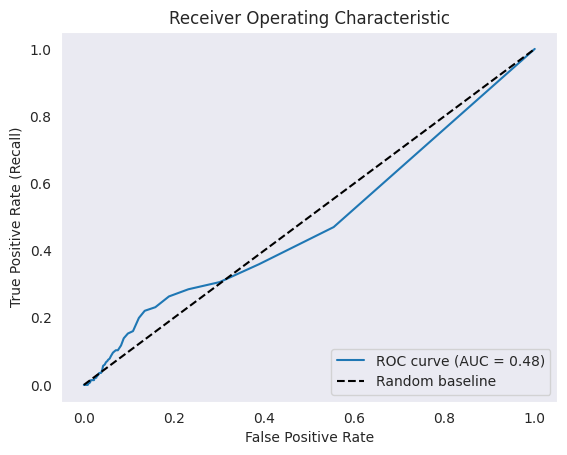

In [181]:
fpr, tpr, _ = roc_curve(ewma_test_out, ewma_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [182]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(rm_test_out, rm_pred).ravel()

sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity (Recall): 0.00
Specificity: 0.99


In [183]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(ff_test_out, ff_pred).ravel()

sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity (Recall): 0.01
Specificity: 0.99


In [184]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(ewma_test_out, ewma_pred).ravel()

sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity (Recall): 0.00
Specificity: 0.99


## Incorporating Survey Data

In [41]:
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

In [31]:
fitbit_data = set_nan_zero(fitbit_data, result_col)

In [185]:
def fix_survey_cols(df, cols):
    df = df.copy()

    # Sort by user and date to ensure proper shifting
    df = df.sort_values(by=['fitbit_user_id', 'date'])

    # Shift survey columns backward by one day within each user group
    for col in cols:
        df[f'{col}_cur'] = df.groupby('fitbit_user_id')[col].shift(-1)

    return df

fitbit_data = fix_survey_cols(fitbit_data, survey_cols)

In [33]:
fitbit_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day,diet_cur,medication_cur,symptoms_cur
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,2.0,2.0,1.0,NaN,NaN,0,NaN,NaN,0.0,1.0,2.0,1.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,1.0,2.0,1.0,270.0,46.0,1,NaN,NaN,0.0,1.0,2.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,1.0,2.0,0.0,141.0,23.0,2,NaN,NaN,0.0,2.0,2.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,2.0,2.0,0.0,172.0,53.0,3,NaN,NaN,0.0,2.0,2.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,2.0,2.0,0.0,99.0,5.0,4,NaN,NaN,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,NaN,NaN,NaN,175,NaN,NaN,0.0,NaN,NaN,NaN
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,NaN,NaN,NaN,176,NaN,NaN,0.0,NaN,NaN,NaN
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,NaN,NaN,NaN,177,NaN,NaN,0.0,NaN,NaN,NaN
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,NaN,NaN,NaN,178,NaN,NaN,0.0,NaN,NaN,NaN


In [186]:
# Clears rows with empty columns to start
def prelim_row_removal_2(df, cols):
    cleaned_groups = []

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy()
        to_remove = []

        for idx, row in group.iterrows():
            if row[cols].isna().all() and row['study_group'] != "No App":
                to_remove.append(idx)
            else:
                break  # Stop as soon as we hit a row with any non-NaN value

        group = group.drop(index=to_remove)
        cleaned_groups.append(group)

    return pd.concat(cleaned_groups).reset_index(drop=True)


fitbit_data = set_nan_zero(fitbit_data, result_col)
fitbit_data = prelim_row_removal_2(fitbit_data, measure_cols+survey_cols)

In [35]:
fitbit_data = mark_day_for_removal(fitbit_data, measure_cols+survey_cols, 3, 7)

In [36]:
all_impute = impute_forward_fill(fitbit_data, measure_cols+survey_cols)

In [37]:
final_all_data = final_clean(all_impute, measure_cols+survey_cols)

In [38]:
all_train, all_val, all_test = group_split(final_all_data)

all_test_in, all_test_out = split_data(all_test, measure_cols+survey_cols, result_col)
all_val_in, all_val_out = split_data(all_val, measure_cols+survey_cols, result_col)
all_train_in, all_train_out = split_data(all_train, measure_cols+survey_cols, result_col)

all_test_out = all_test_out.astype(int)
all_val_out = all_val_out.astype(int)
all_train_out = all_train_out.astype(int)

In [39]:
rf_all = run_rf(all_train_in, all_train_out, all_val_in, all_val_out)

1.0
0.9333333333333333


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

all_pred = rf_all.predict(all_test_in)

print("Confusion Matrix:")
print(confusion_matrix(all_test_out, all_pred))
print("\nClassification Report:")
print(classification_report(all_test_out, all_pred))

Confusion Matrix:
[[3119  210]
 [ 684   59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87      3329
           1       0.22      0.08      0.12       743

    accuracy                           0.78      4072
   macro avg       0.52      0.51      0.50      4072
weighted avg       0.71      0.78      0.74      4072



Text(0.5, 1.0, 'Confusion Matrix - All')

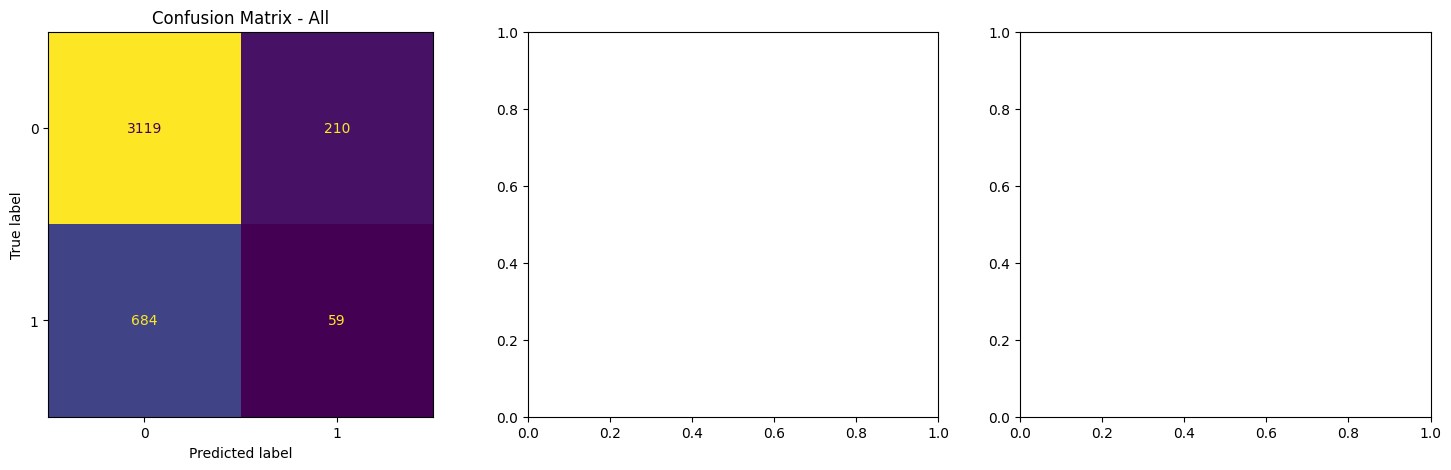

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# First confusion matrix (rm_test_out vs rm_pred)
ConfusionMatrixDisplay.from_predictions(all_test_out, all_pred, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix - All")

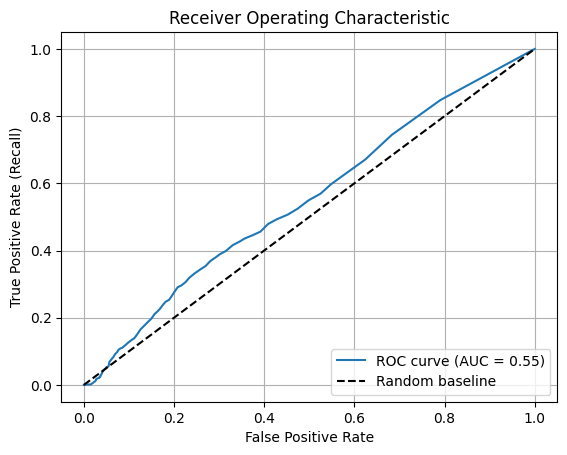

In [44]:
rm_proba = rf_all.predict_proba(all_test_in)[:, 1]  # Probabilities for class 1
rm_pred = rf_all.predict(all_test_in)               # Binary predictions

fpr, tpr, _ = roc_curve(all_test_out, rm_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [45]:
importance_df = pd.DataFrame({
    'feature': all_test_in.columns,
    'importance': rf_all.feature_importances_
}).sort_values('importance', ascending=False)

In [46]:
importance_df.head(10)

,feature,importance
0,avgWeight_per_day,0.316240
2,heart,0.185315
1,calories,0.177165
3,steps,0.175963
6,symptoms,0.086610
4,diet,0.042760
5,medication,0.015946


In [47]:
import seaborn as sns
sns.set_style('darkgrid')

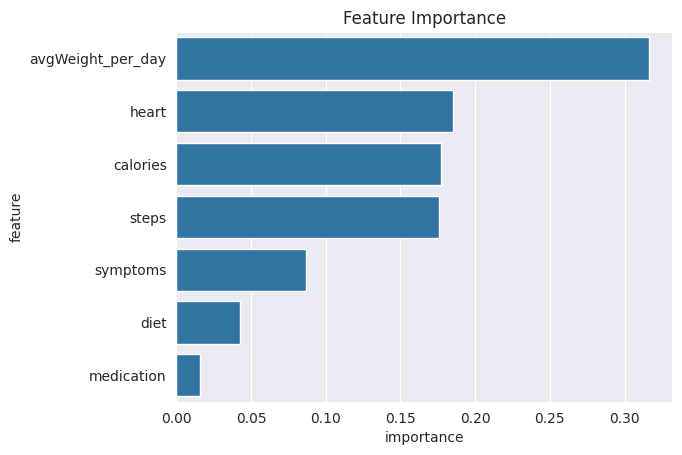

In [48]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

In [49]:
# Confusion matrix from train data
all_pred = rf_all.predict(all_train_in)

print("Confusion Matrix:")
print(confusion_matrix(all_train_out, all_pred))

Confusion Matrix:
[[11494     0]
 [    0  1697]]


In [50]:
# Confusion matrix from validation data
all_pred = rf_all.predict(all_val_in)

print("Confusion Matrix:")
print(confusion_matrix(all_val_out, all_pred))

Confusion Matrix:
[[1717   28]
 [ 107  173]]


# Hyperparamter Tuning

In [51]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(all_train_in, all_train_out)

In [52]:
base_train_acc = base_model.score(all_train_in, all_train_out)
base_val_acc = base_model.score(all_val_in, all_val_out)

In [53]:
base_accs = base_train_acc, base_val_acc
base_accs

(1.0, 0.9333333333333333)

In [54]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)
model.fit(all_train_in, all_train_out)
model.score(all_train_in, all_train_out), model.score(all_val_in, all_val_out)

(0.9974982942915624, 0.9293827160493827)

In [55]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(all_train_in, all_train_out)
model.score(all_train_in, all_train_out), model.score(all_val_in, all_val_out)

(1.0, 0.9224691358024691)

In [56]:
# Confusion matrix from validation data
all_pred = model.predict(all_test_in)

print("Confusion Matrix:")
print(confusion_matrix(all_test_out, all_pred))

Confusion Matrix:
[[3113  216]
 [ 692   51]]


In [103]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(rm_train_in, rm_train_out)

    rm_pred = model.predict(rm_test_in)
    rm_proba = model.predict_proba(rm_test_in)[:, 1]  # Probability of class 1

    print("Confusion Matrix:")
    print(confusion_matrix(rm_test_out, rm_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(rm_test_out, rm_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return model.score(rm_train_in, rm_train_out), model.score(rm_val_in, rm_val_out)


Confusion Matrix:
[[4121  292]
 [ 971  204]]


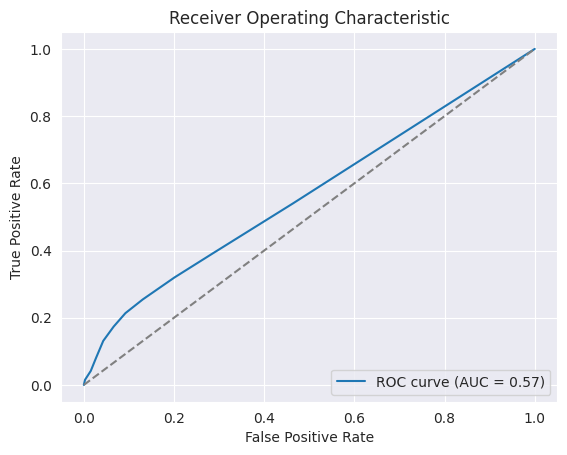

(0.9936233316856155, 0.5154308617234469)

In [104]:
test_params(n_estimators=10)

Confusion Matrix:
[[4134  279]
 [ 984  191]]


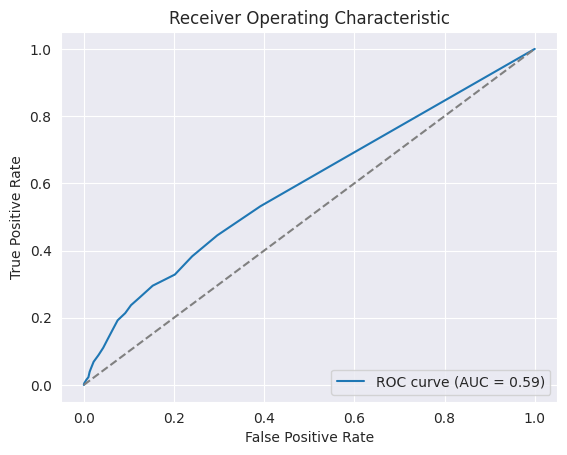

(0.9973801285219971, 0.5154308617234469)

In [105]:
test_params(n_estimators=20)

Confusion Matrix:
[[4155  258]
 [ 964  211]]


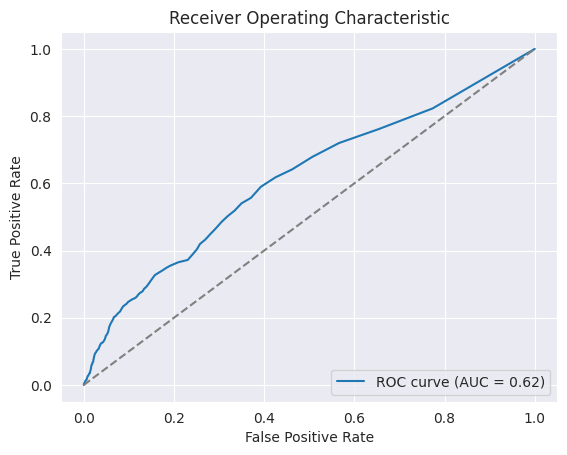

(1.0, 0.5082164328657315)

In [106]:
test_params(max_features='log2')

Confusion Matrix:
[[4155  258]
 [ 964  211]]


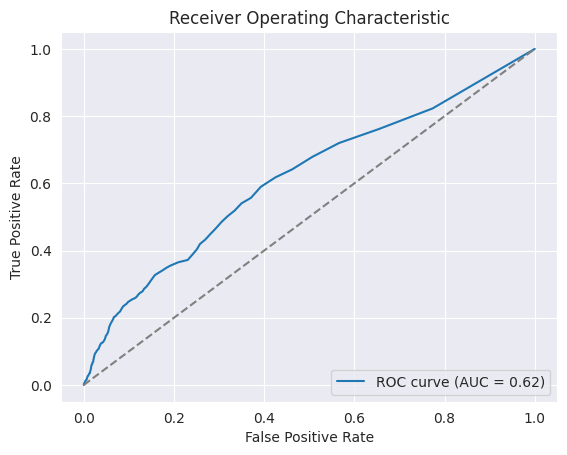

(1.0, 0.5082164328657315)

In [107]:
test_params(max_features='sqrt')

Confusion Matrix:
[[4155  258]
 [ 964  211]]


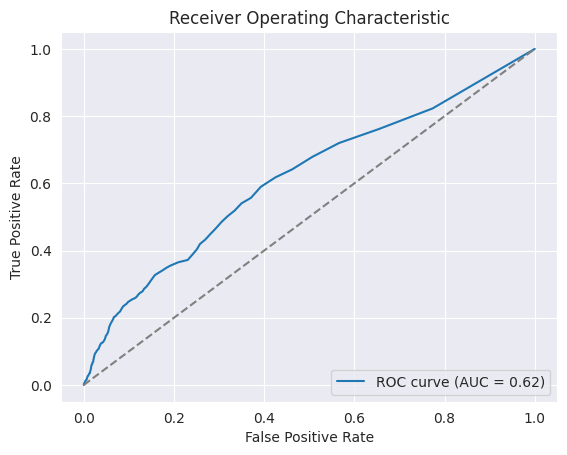

(1.0, 0.5082164328657315)

In [108]:
test_params(max_features='sqrt')

Confusion Matrix:
[[4364   49]
 [1154   21]]


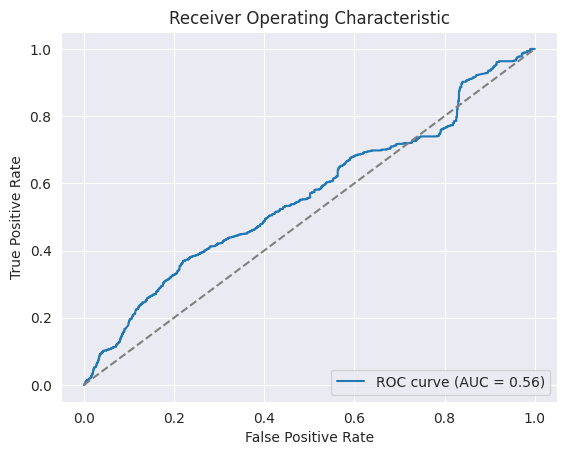

(0.881463173504696, 0.5254509018036072)

In [109]:
test_params(max_depth=5)

Confusion Matrix:
[[4142  271]
 [ 971  204]]


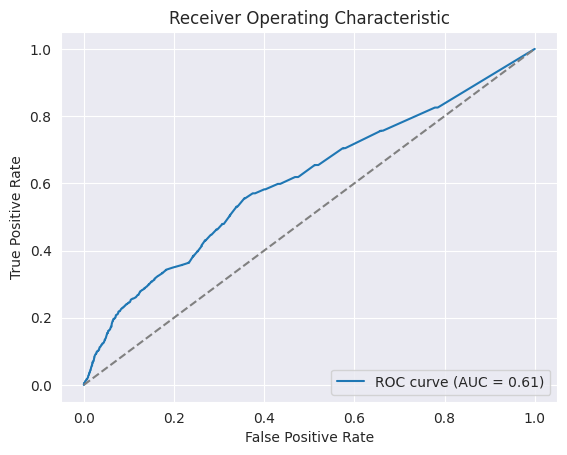

(1.0, 0.5082164328657315)

In [110]:
test_params(max_depth=25)

Confusion Matrix:
[[4360   53]
 [1134   41]]


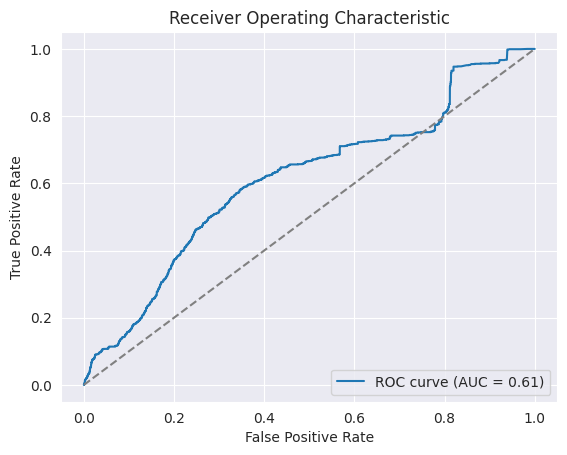

(0.89268413247652, 0.5186372745490982)

In [111]:
test_params(max_leaf_nodes=2**5)

Confusion Matrix:
[[4150  263]
 [1002  173]]


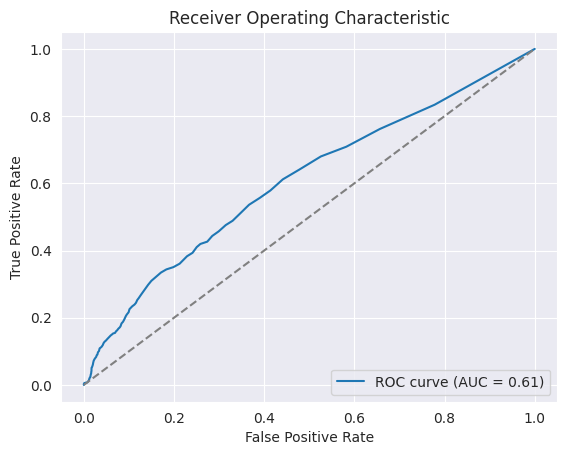

(1.0, 0.4925851703406814)

In [112]:
test_params(max_leaf_nodes=2**20)

Confusion Matrix:
[[4159  254]
 [ 974  201]]


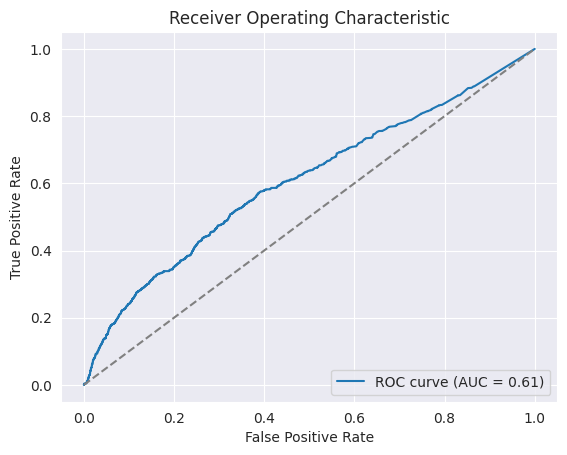

(0.9869995056846268, 0.48617234468937875)

In [113]:
test_params(min_samples_split=3, min_samples_leaf=2)

Confusion Matrix:
[[4271  142]
 [1103   72]]


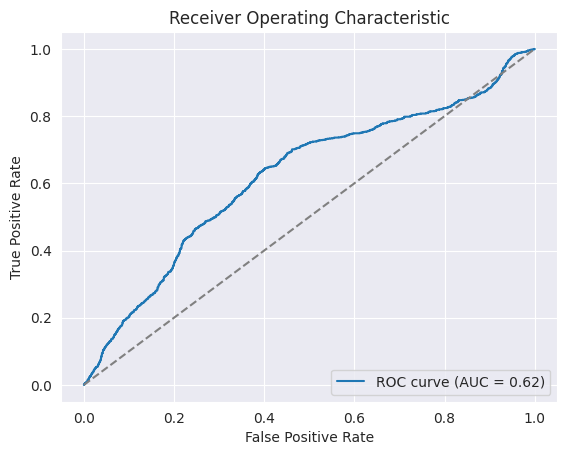

(0.9074641621354425, 0.535871743486974)

In [114]:
test_params(min_samples_split=100, min_samples_leaf=60)

Confusion Matrix:
[[4147  266]
 [ 973  202]]


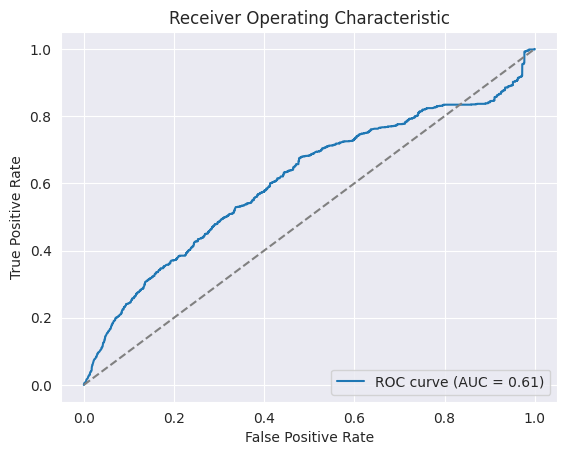

(0.9998022738507167, 0.49298597194388777)

In [115]:
test_params(min_impurity_decrease=1e-6)

Confusion Matrix:
[[4413    0]
 [1175    0]]


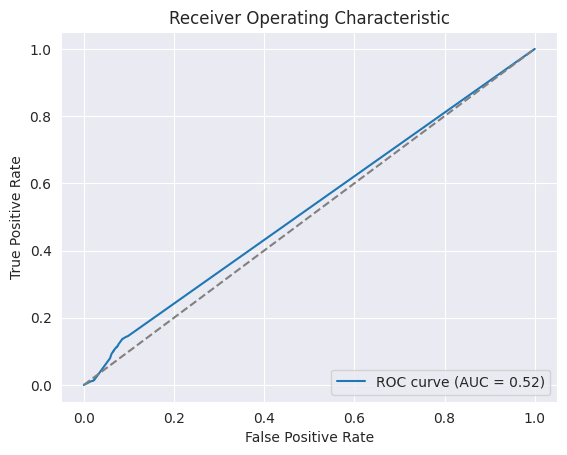

(0.854819574888779, 0.5450901803607214)

In [116]:
test_params(min_impurity_decrease=1e-2)

Confusion Matrix:
[[4131  282]
 [ 975  200]]


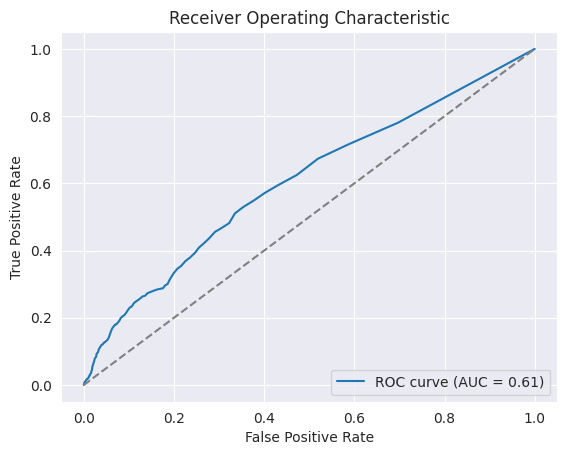

(1.0, 0.5006012024048097)

In [117]:
test_params(bootstrap=False)

Confusion Matrix:
[[4164  249]
 [ 980  195]]


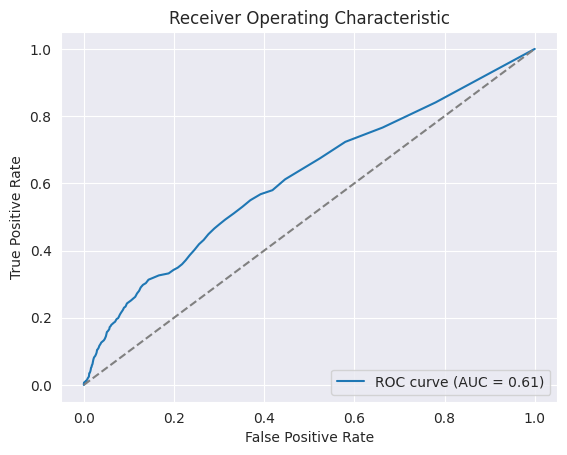

(0.9999011369253584, 0.4905811623246493)

In [118]:
test_params(max_samples=0.9)

Confusion Matrix:
[[4205  208]
 [1007  168]]


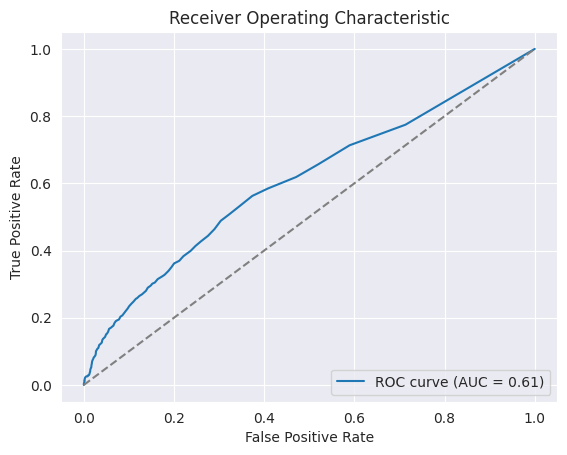

(1.0, 0.5202404809619239)

In [119]:
test_params(class_weight='balanced')

In [109]:
model.classes_

array([0., 1.])

Confusion Matrix:
[[4158  255]
 [1028  147]]


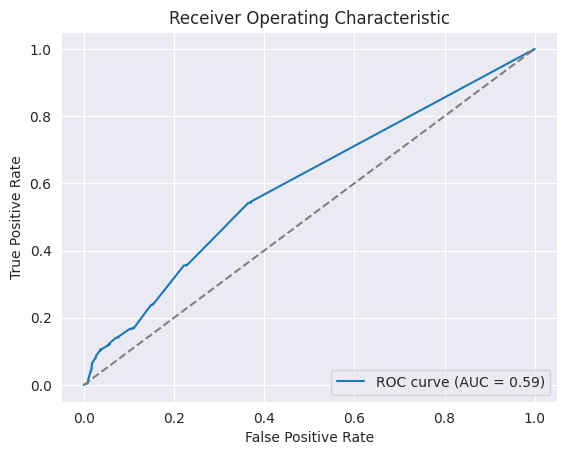

(0.9999011369253584, 0.5166332665330662)

In [120]:
test_params(min_impurity_decrease=1e-6,
            bootstrap=False,
            max_leaf_nodes=2**20,
            class_weight='balanced',
            max_depth = 25,
            n_estimators=10)

## Solving Issue: Not Working at All

Confusion Matrix:
[[4076  337]
 [ 923  252]]


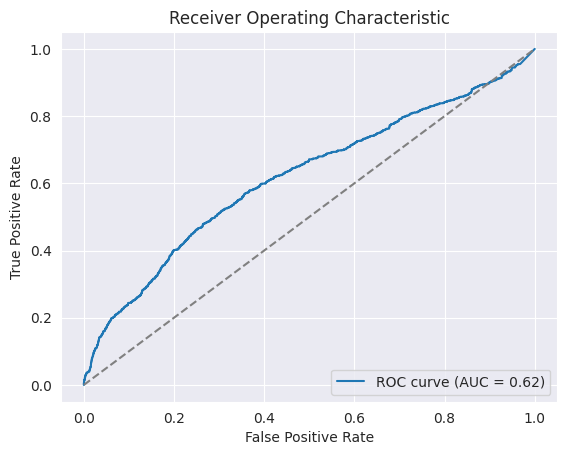

(0.9870489372219476, 0.4849699398797595)

In [121]:
test_params(n_estimators=400,
            max_depth=None,          # let trees grow deep
            min_samples_leaf=1,
            class_weight='balanced', # weight ∝ 1 / class frequency
            )

Confusion Matrix:
[[3513  900]
 [ 674  501]]


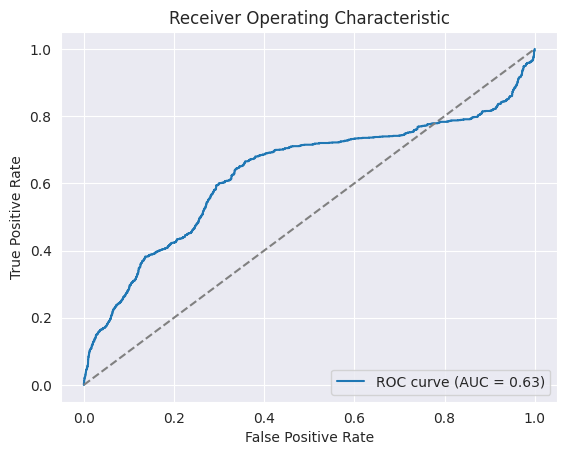

(0.8301532377656945, 0.3595190380761523)

In [124]:
test_params(n_estimators=600,
            max_depth=6,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight='balanced_subsample',
            bootstrap=True,
            min_samples_split=2,
            )

In [113]:
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, roc_curve,
    f1_score, confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def choose_threshold(clf, X, y, metric='f1', n_splits=5):
    """
    Returns the mean best threshold across CV folds and the per-fold scores.
    metric ∈ {'f1', 'youden', 'precision', 'recall', 'cost'}
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_thresh, fold_scores = [], []

    for train, val in skf.split(X, y):
        model = clone(clf).fit(X.iloc[train], y.iloc[train])
        probs  = model.predict_proba(X.iloc[val])[:, 1]

        if metric == 'precision' or metric == 'recall' or metric == 'f1':
            prec, rec, thr = precision_recall_curve(y.iloc[val], probs)
            if metric == 'precision':
                score_vec = prec[1:]        # first element is undefined
            elif metric == 'recall':
                score_vec = rec[1:]
            else:   # f1
                score_vec = 2*prec[1:]*rec[1:] / (prec[1:]+rec[1:] + 1e-9)
        elif metric == 'youden':
            tpr, fpr, thr = roc_curve(y.iloc[val], probs)
            score_vec = tpr - fpr          # maximise TPR-FPR
        elif metric == 'cost':
            # example costs
            cost_fn, cost_fp = 10, 1
            tpr, fpr, thr = roc_curve(y.iloc[val], probs)
            fn_rate = 1 - tpr
            score_vec = -(cost_fn*fn_rate + cost_fp*fpr)   # minimise cost → maximise negative cost
        else:
            raise ValueError("Unknown metric")

        idx = np.nanargmax(score_vec)
        best_thresh.append(thr[idx])
        fold_scores.append(score_vec[idx])

    return np.mean(best_thresh), best_thresh, fold_scores


In [115]:
rf = RandomForestClassifier(
        n_estimators=400,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
)

thr, fold_thr, fold_scores = choose_threshold(rf, all_train_in, all_train_out,
                                              metric='recall', n_splits=10)
print(f"Chosen threshold = {thr:.3f}  (per-fold: {fold_thr})")

# Re-fit on full training data and apply
rf.fit(all_train_in, all_train_out)
probs = rf.predict_proba(all_test_in)[:,1]
y_pred = (probs >= thr).astype(int)

print(confusion_matrix(all_test_out, y_pred))
print(f"Test-F1 = {f1_score(all_test_out, y_pred):.3f}")


Chosen threshold = 0.000  (per-fold: [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)])
[[   0 4519]
 [   0    9]]
Test-F1 = 0.004


In [120]:
rf.fit(all_train_in, all_train_out)
probs = rf.predict_proba(all_test_in)[:,1]
y_pred = (probs >= 0.01).astype(int)

print(confusion_matrix(all_test_out, y_pred))

[[4426   93]
 [   9    0]]


### Adjusting target

In [6]:
# Patient has visit -> all days are 1
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Loop through each user group
for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    if (group['visit_day'] == 1).any():
        # Set all rows for this user to 1 in the original dataframe
        fitbit_data.loc[fitbit_data['fitbit_user_id'] == user_id, 'visit_day'] = 1

In [157]:
import pandas as pd

# Load your data
fitbit_data = pd.read_csv('/content/drive/My Drive/colab_data/data_daily_w_visits.csv')

# Iterate by user
for user_id, group in fitbit_data.groupby('fitbit_user_id'):
    visit_days = group[group['visit_day'] == 1]['days'].values

    for visit_day in visit_days:
        # Get range from (visit_day - 14) to (visit_day + 14)
        lower = visit_day - 14
        upper = visit_day + 14

        # Create mask for the affected rows for this user
        mask = (
            (fitbit_data['fitbit_user_id'] == user_id) &
            (fitbit_data['days'] >= lower) &
            (fitbit_data['days'] <= upper)
        )

        fitbit_data.loc[mask, 'visit_day'] = 1


In [10]:
fitbit_data.describe()

,Unnamed: 0,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,death,visit_day
count,44820.000000,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,23857.000000,23862.000000,23866.000000,30702.000000,30702.000000,44820.000000,80.0,9180.0
mean,22409.500000,152.518072,189.784778,2235.929534,65.401733,5234.779148,1.612986,1.945772,0.350289,383.079734,54.538662,89.500000,0.0,1.0
std,12938.563869,86.485919,45.383202,767.532572,9.289836,4163.937032,0.609961,0.260871,0.530075,126.255121,29.144155,51.961302,0.0,0.0
min,0.000000,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,11204.750000,80.000000,160.275874,1786.000000,60.000000,2201.000000,1.000000,2.000000,0.000000,317.250000,36.000000,44.750000,0.0,1.0
50%,22409.500000,152.000000,183.644846,2151.500000,64.000000,4441.000000,2.000000,2.000000,0.000000,391.000000,53.000000,89.500000,0.0,1.0
75%,33614.250000,222.000000,211.643520,2557.000000,72.000000,7291.000000,2.000000,2.000000,1.000000,457.000000,70.000000,134.250000,0.0,1.0
max,44819.000000,307.000000,398.705527,13442.000000,118.000000,37020.000000,2.000000,2.000000,2.000000,1545.000000,435.000000,179.000000,0.0,1.0
